In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import torch
import fb_utils as fb
import time

In [6]:
def tight_flat_spec(w):
    """
    Construction of a tight filterbank with flat spectrum
    :input: analysis filterbank w
    :return: filterbank with flat spectrum
    """
    M, N = w.shape
    w_freqz = np.fft.fft(w,axis=1).T
    w_tight = np.zeros((M, N), dtype=np.complex64)
    for k in range(N):
        H = w_freqz[k, :]
        U = H / np.linalg.norm(H)
        w_tight[:,k] = np.conj(U)
    w_tight = np.fft.ifft(w_tight.T, axis=0).T
    return w_tight

In [7]:
def tight(w):
    """
    Construction of the canonical tight filterbank
    :input: analysis filterbank
    :return: canonical tight filterbank
    """
    w_freqz = np.fft.fft(w,axis=1)
    lp = np.sum(np.abs(w_freqz)**2,axis=0)
    w_freqz_tight = w_freqz * lp**(-0.5)
    return np.fft.ifft(w_freqz_tight,axis=1)

In [97]:
def fir_tight(w, supp, eps=0.01, print_kappa=True):
    """
    Iterative construction of a tight filterbank with a given support
    :param w: analysis filterbank
    :param supp: desired support of the tight filterbank
    :param eps: desired precision for kappa = B/A
    :return: tight filterbank
    """
    A,B = fb.frame_bounds_lp(w)
    w_tight = w.copy()
    kappa = [B/A]
    error = [0]
    it = 0
    if print_kappa:
            print('kappa:', '%.4f' % kappa[it], ', error:', '%.4f' % error[it])
    while B/A > 1+eps:
        it += 1
        w_tight = tight(w_tight)
        w_tight[:,supp:] = 0
        w_tight = np.real(w_tight)
        A,B = fb.frame_bounds_lp(w_tight)
        kappa.append(B/A)
        error.append(np.linalg.norm(w-w_tight)/np.linalg.norm(w))
        if print_kappa:
            print('kappa:', '%.4f' % kappa[it], ', error:', '%.4f' % error[it])
    return w_tight, np.array(kappa), np.array(error)

In [36]:
N = 16000
J = 256
T = 512
w = fb.random_filterbank(N, J, T, tight=False, support_only=False, to_torch=False)
#w_ill = w+np.roll(w,1,axis=0)+np.roll(w,2,axis=0)+np.roll(w,3,axis=0)+np.roll(w,4,axis=0)
#w_ill[1:100,:]=w_ill[1:100,:]*10**(-10)

w_tight, kappa, error = fir_tight(w, T, eps=0.01)

In [126]:
kappa_list = []
error_list = []
num = 10
for i in range(num):
    c = np.random.rand(J)
    w_ill = np.zeros((J,N))
    for i in range(J):
        w_ill[i,:T] = c[i]**np.arange(T)
    w_tight, kappa, error = fir_tight(w_ill, T, eps=0.001)
    kappa+=kappa
    error+=error
kappa = kappa/num
error = error/num

kappa: 333.9773 , error: 0.0000
kappa: 5.1178 , error: 0.9745
kappa: 1.8102 , error: 0.9761
kappa: 1.2639 , error: 0.9770
kappa: 1.0996 , error: 0.9774
kappa: 1.0394 , error: 0.9776
kappa: 1.0158 , error: 0.9777
kappa: 1.0068 , error: 0.9777
kappa: 1.0030 , error: 0.9777
kappa: 1.0014 , error: 0.9778
kappa: 1.0006 , error: 0.9778
kappa: 1147.3771 , error: 0.0000
kappa: 6.0511 , error: 0.9782
kappa: 1.8887 , error: 0.9796
kappa: 1.2790 , error: 0.9804
kappa: 1.1031 , error: 0.9807
kappa: 1.0402 , error: 0.9809
kappa: 1.0173 , error: 0.9809
kappa: 1.0078 , error: 0.9810
kappa: 1.0036 , error: 0.9810
kappa: 1.0017 , error: 0.9810
kappa: 1.0008 , error: 0.9810
kappa: 215.7732 , error: 0.0000
kappa: 4.7311 , error: 0.9700
kappa: 1.7699 , error: 0.9716
kappa: 1.2540 , error: 0.9725
kappa: 1.0963 , error: 0.9730
kappa: 1.0382 , error: 0.9732
kappa: 1.0163 , error: 0.9733
kappa: 1.0073 , error: 0.9733
kappa: 1.0033 , error: 0.9733
kappa: 1.0015 , error: 0.9733
kappa: 1.0007 , error: 0.9733
kap

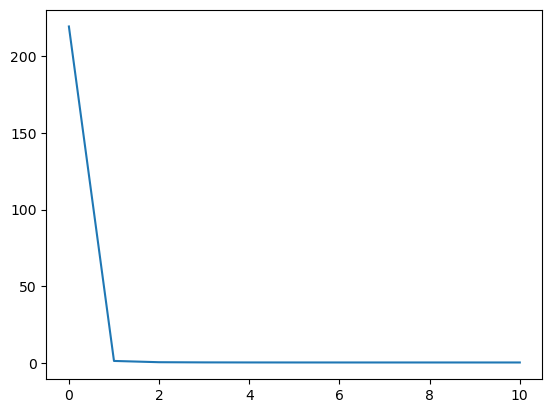

In [127]:
plt.plot(kappa)

In [98]:
w_tight, kappa, error = fir_tight(w_ill, T, eps=0.001)

kappa: 808.7336 , error: 0.0000
kappa: 5.7809 , error: 0.9767
kappa: 1.8635 , error: 0.9782
kappa: 1.2731 , error: 0.9791
kappa: 1.1010 , error: 0.9795
kappa: 1.0406 , error: 0.9797
kappa: 1.0176 , error: 0.9797
kappa: 1.0078 , error: 0.9798
kappa: 1.0035 , error: 0.9798
kappa: 1.0016 , error: 0.9798
kappa: 1.0007 , error: 0.9798


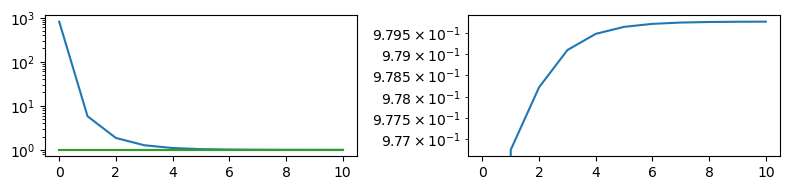

In [99]:
plt.figure(figsize=(8,2))

x = np.arange(len(kappa))

plt.subplot(1,2,1)
plt.plot(x,kappa[:])
plt.plot(x,np.ones(len(kappa)))
plt.plot(x,np.ones(len(kappa))+0.01)
#plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(x,error[:])
#plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

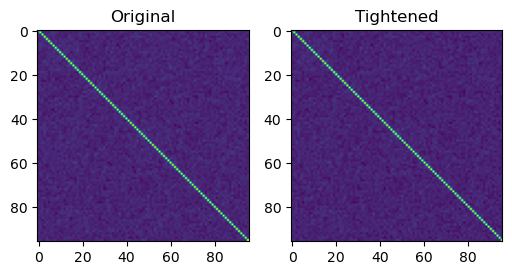

In [50]:
# compute cross-correlation matrix of w_tight
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(np.corrcoef([w[k,1:] for k in range(w.shape[0])] ))
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(np.corrcoef([w_tight[k,1:] for k in range(w_tight.shape[0])] ))
plt.title('Tightened')
plt.show()

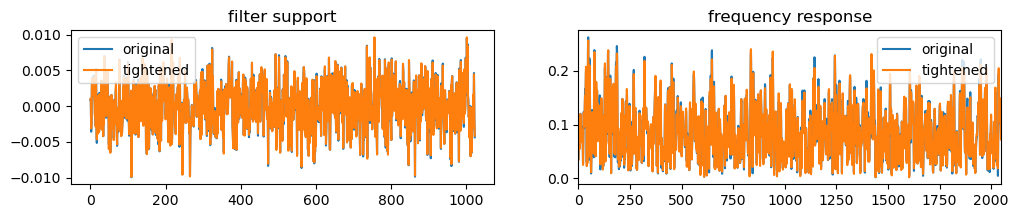

In [51]:
# plot frequency response of w_tight
# 2 plots next to eachother: one for w, one for w_tight

plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(w[0,:T].T, label='original')
plt.plot(w_tight[0,:T].T, label='tightened')
plt.title('filter support')
plt.legend()
plt.subplot(1,2,2)
w_freqz = np.abs(np.fft.fft(w,axis=1).T)
plt.plot(w_freqz[:,0], label='original')
w_tight_freqz = np.abs(np.fft.fft(w_tight,axis=1).T)
plt.plot(w_tight_freqz[:,0], label='tightened')
plt.xlim([0,N//2+1])
plt.title('frequency response')
plt.legend()
plt.show()